<a href="https://colab.research.google.com/github/guilhermegranchopro/Eco-AI.ly/blob/main/LSTM/Renewable_Percentage/Live_Predictions_LSTM_Renewable_Percentage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa: Implementação em Tempo Real

Usar a API do Electricity Maps para obter os últimos 24 datapoints de intensidade de carbono e alimentar a LSTM treinada para prever os próximos 24 valores na escala de 0 a 5.

1. Configurar a API do Electricity Maps:

  * Criar um script para buscar os últimos 24 valores de LCA via API.
  * Garantir que os dados obtidos estejam no mesmo formato do dataset original.

2. Pré-processar os Dados ao Vivo:

  * Converter timestamps corretamente.
  * Normalizar os dados para que fiquem no mesmo padrão usado no treinamento.

3. Carregar o Modelo Treinado:

  * Importar o modelo LSTM treinado armazenado no Google Drive.

4. Fazer a Previsão das Próximas 24 Horas:

  * Alimentar os dados ao vivo no modelo e obter a previsão.

5. Interpretar e Exibir a Previsão:

  * Converter as previsões na escala de 0 a 5.
  * Exibir os resultados de forma clara.

In [1]:
# Script para Obter Dados ao Vivo e Fazer Previsão com a LSTM

import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Conectar ao Google Drive (necessário para carregar o modelo salvo)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Configurações da API do Electricity Maps
API_KEY = 'czG7nq1wv9OHi1phrXUn'  # Chave da API fornecida
REGION = 'PT'  # Código da região (Portugal)
URL = f'https://api.electricitymap.org/v3/power-breakdown/history?zone={REGION}'
HEADERS = {'auth-token': API_KEY}

In [4]:
# Função para obter os últimos 24 valores de LCA via API
def obter_dados_api():
    response = requests.get(URL, headers=HEADERS)
    if response.status_code == 200:
        data = response.json()['history']
        df = pd.DataFrame(data)
        df['datetime'] = pd.to_datetime(df['datetime'])  # Converter timestamps
        df = df.sort_values(by='datetime', ascending=True)  # Garantir ordem temporal
        df = df[['datetime', 'renewablePercentage']]  # Selecionar colunas relevantes
        df.rename(columns={'renewablePercentage': 'RP'}, inplace=True)
        return df.tail(24)  # Retornar as últimas 24 horas
    else:
        print(f"Erro ao acessar API: {response.status_code}")
        return None

In [5]:
# Função para carregar o modelo treinado
def carregar_modelo():
    modelo_path = '/content/drive/My Drive/Modelos/LSTM_RP_Model.keras'
    return tf.keras.models.load_model(modelo_path)

In [6]:
# Função para normalizar os dados com MinMaxScaler
def normalizar_dados(df, scaler):
    df['RP'] = scaler.fit_transform(df[['RP']])  # Normalizar a coluna LCA
    return df

In [7]:
# Função para prever a intensidade de carbono nas próximas 24 horas
def fazer_previsao(modelo, dados):
    dados_formatados = dados['RP'].values.reshape(1, 24, 1)  # Formatar para entrada da LSTM
    previsao = modelo.predict(dados_formatados)
    previsao_classe = np.argmax(previsao, axis=1)  # Obter a classe mais provável
    return previsao_classe

In [8]:
# Executar o pipeline
print("Obtendo dados ao vivo...")
df_dados_atuais = obter_dados_api()
df_dados_atuais

Obtendo dados ao vivo...


,datetime,RP
0,2025-02-01 23:00:00+00:00,90
1,2025-02-02 00:00:00+00:00,88
2,2025-02-02 01:00:00+00:00,88
3,2025-02-02 02:00:00+00:00,88
4,2025-02-02 03:00:00+00:00,88
5,2025-02-02 04:00:00+00:00,88
6,2025-02-02 05:00:00+00:00,88
7,2025-02-02 06:00:00+00:00,88
8,2025-02-02 07:00:00+00:00,88
9,2025-02-02 08:00:00+00:00,89


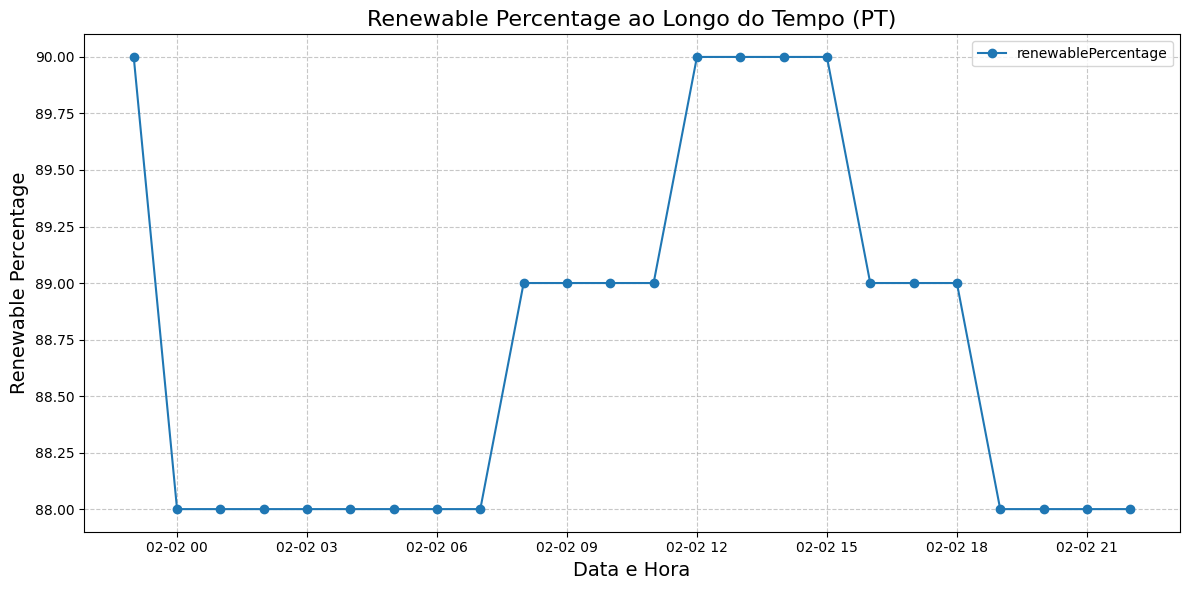

In [9]:
# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(df_dados_atuais['datetime'], df_dados_atuais['RP'], marker='o', linestyle='-', label='renewablePercentage')
plt.title("Renewable Percentage ao Longo do Tempo (PT)", fontsize=16)
plt.xlabel("Data e Hora", fontsize=14)
plt.ylabel("Renewable Percentage", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print("Normalizando dados...")
scaler = MinMaxScaler()
df_dados_atuais = normalizar_dados(df_dados_atuais, scaler)

Normalizando dados...


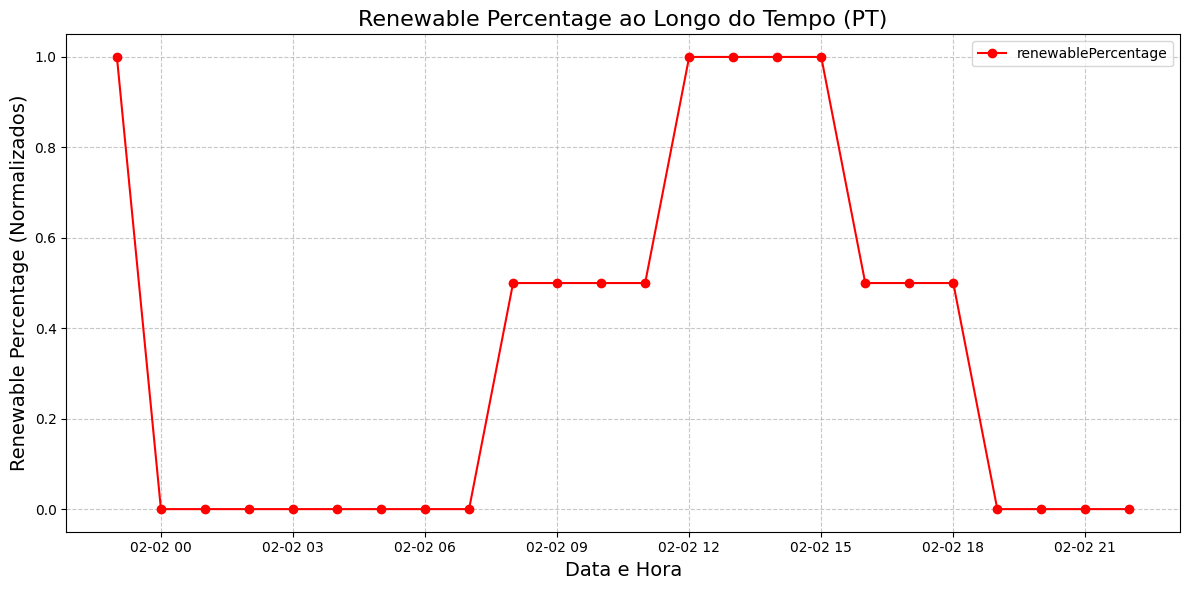

In [11]:
# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(df_dados_atuais['datetime'], df_dados_atuais['RP'], marker='o', linestyle='-', label='renewablePercentage', color='red')
plt.title("Renewable Percentage ao Longo do Tempo (PT)", fontsize=16)
plt.xlabel("Data e Hora", fontsize=14)
plt.ylabel("Renewable Percentage (Normalizados)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
print("Carregando modelo...")
modelo = carregar_modelo()

Carregando modelo...


In [13]:
print("Fazendo previsão para as próximas 24 horas...")
previsao = fazer_previsao(modelo, df_dados_atuais)

Fazendo previsão para as próximas 24 horas...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


In [14]:
print("Previsão das próximas 24 horas (Escala 0 a 5):")
print(previsao)

Previsão das próximas 24 horas (Escala 0 a 5):
[2]
